In [28]:
import os
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
!gdown --id 17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X
From (redirected): https://drive.google.com/uc?id=17qjW3qhjaWSlLZvjMlbeTVi9y7Nx1N9X&confirm=t&uuid=64830b88-878f-4193-9a2e-bc8126d03758
To: /content/dataset.zip
100% 81.0M/81.0M [00:00<00:00, 88.8MB/s]


In [3]:
import zipfile

current_dir = os.getcwd()
local_zip = './dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
# Set the dataset folder path
dataset_folder = 'dataset'

# Get the list of class folders
class_folders = [f for f in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, f))]

# Create lists to store the image file paths and their corresponding labels
image_files = []
labels = []

# Iterate through each class folder
for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)
    image_files_in_class = [os.path.join(class_folder_path, f) for f in os.listdir(class_folder_path) if f.endswith('.jpg')]
    image_files.extend(image_files_in_class)
    labels.extend([class_folder] * len(image_files_in_class))

# Convert the lists to numpy arrays
image_files = np.array(image_files)
labels = np.array(labels)

# Split the data into training and testing sets
train_files, test_files, train_labels, test_labels = train_test_split(image_files, labels, test_size=0.3, random_state=42, stratify=labels)

# Create train and test folders if they don't exist
if not os.path.exists(os.path.join(dataset_folder, 'train')):
    os.makedirs(os.path.join(dataset_folder, 'train'))
if not os.path.exists(os.path.join(dataset_folder, 'test')):
    os.makedirs(os.path.join(dataset_folder, 'test'))

# Move images to train and test folders
for file in train_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'train', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'train', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'train', class_folder, os.path.basename(file)))

for file in test_files:
    class_folder = os.path.basename(os.path.dirname(file))
    if not os.path.exists(os.path.join(dataset_folder, 'test', class_folder)):
        os.makedirs(os.path.join(dataset_folder, 'test', class_folder))
    os.rename(file, os.path.join(dataset_folder, 'test', class_folder, os.path.basename(file)))

In [5]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/test"

train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(229, 229),
    batch_size=32,
    class_mode='categorical'
)

Found 339 images belonging to 64 classes.
Found 146 images belonging to 64 classes.


In [6]:
classes_train = train_generator.class_indices
classes_test = test_generator.class_indices
print("Training samples:", train_generator.samples)
print("Testing samples:", test_generator.samples)

Training samples: 339
Testing samples: 146


In [ ]:
print("Class Indicate", train_generator.class_indices)

Class Indicate {'Astor Chocolate 40g': 0, 'Astor Matcha 40g': 1, 'Bear Brand Susu Steril 189ml': 2, 'Beng-Beng Share It 95g': 3, 'Buavita Apel 245ml': 4, 'Buavita Jambu 245ml': 5, 'Buavita Jeruk 245ml': 6, 'Buavita Korean White Peach 245ml': 7, 'Buavita Leci 245ml': 8, 'Buavita Mangga 245ml': 9, 'Chimi Jagung Bakar 50g': 10, 'Chitato Lite Rumput Laut 68g': 11, 'Cimory Fresh Milk Almond 250ml': 12, 'Cimory Fresh Milk Blueberry 250ml': 13, 'Cimory Fresh Milk Cashew 250ml': 14, 'Cimory Fresh Milk Choco Malt 250ml': 15, 'Cimory Fresh Milk Strawberry 250ml': 16, 'Cimory Yogurt Drink Blueberry 240ml': 17, 'Cimory Yogurt Drink Low Fat Strawberry & Mango 240ml': 18, 'Cimory Yogurt Drink Lychee 240ml': 19, 'Cimory Yogurt Drink Strawberry 240ml': 20, 'Coca Cola Original 390ml': 21, 'Coca Cola Zero Sugar 390ml': 22, 'Fanta Rasa Jeruk 390ml': 23, 'Fanta Rasa Stroberi 390ml': 24, 'French Fries 2000 62g': 25, 'Garuda Kacang Atom Original 17g': 26, 'Hello Panda Chocolate Cream 42g': 27, 'Hello Panda 

In [29]:
# Create a MirroredStrategy to use both GPUs
mirrored_strategy = tf.distribute.MirroredStrategy()

# Compile the model under the MirroredStrategy
with mirrored_strategy.scope():
    # Load pre-trained Resnet model
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

    # Freeze the base model layers
    base_model.trainable = False

    # Compute class weights to handle class imbalance
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
    train_generator.class_weights = class_weights
    test_generator.class_weights = class_weights

    # Define the model architecture
    x = GlobalAveragePooling2D()(base_model.output)
    x = BatchNormalization()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(len(classes_train), activation='softmax')(x)

    # Create the new model
    model = tf.keras.Model(inputs=base_model.input, outputs=x)

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss=CategoricalCrossentropy(),
                  metrics=['accuracy'])


    # Define early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, min_delta=0.001)

    # Train the model
    history = model.fit(train_generator,
                        epochs=100,
                        batch_size=32,
                        validation_data=test_generator,
                        callbacks=[early_stopping],
                        verbose=1)

Epoch 1/100
11/11 [==============================] - 10s 416ms/step - loss: 4.4604 - accuracy: 0.0354 - val_loss: 3.7659 - val_accuracy: 0.1644
Epoch 2/100
11/11 [==============================] - 7s 629ms/step - loss: 2.8928 - accuracy: 0.3658 - val_loss: 3.3552 - val_accuracy: 0.2740
Epoch 3/100
11/11 [==============================] - 4s 336ms/step - loss: 2.0930 - accuracy: 0.5605 - val_loss: 3.0759 - val_accuracy: 0.4041
Epoch 4/100
11/11 [==============================] - 4s 334ms/step - loss: 1.5255 - accuracy: 0.7375 - val_loss: 2.8659 - val_accuracy: 0.4589
Epoch 5/100
11/11 [==============================] - 6s 535ms/step - loss: 1.1279 - accuracy: 0.8378 - val_loss: 2.7060 - val_accuracy: 0.4863
Epoch 6/100
11/11 [==============================] - 4s 308ms/step - loss: 0.8148 - accuracy: 0.9115 - val_loss: 2.5746 - val_accuracy: 0.5137
Epoch 7/100
11/11 [==============================] - 4s 333ms/step - loss: 0.6005 - accuracy: 0.9440 - val_loss: 2.4462 - val_accuracy: 0.541

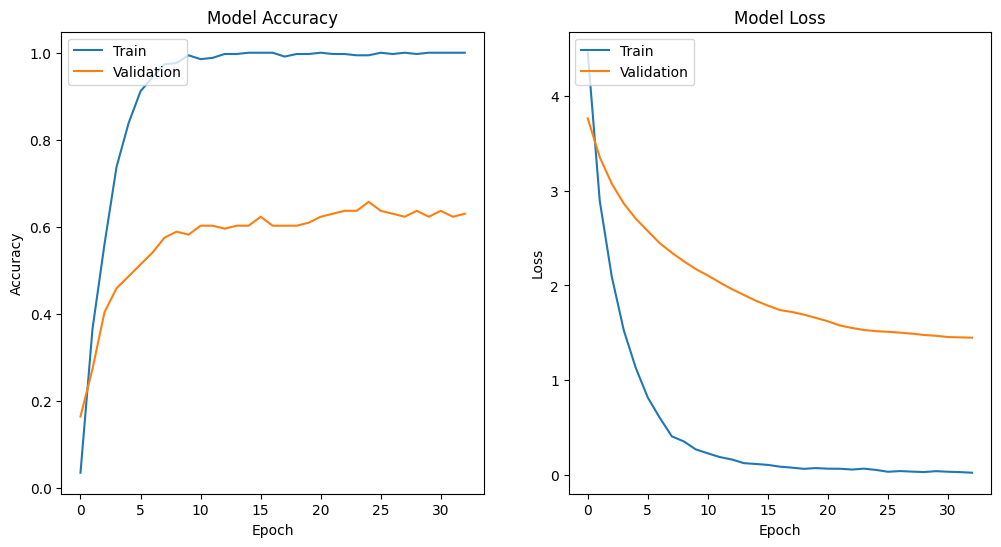

In [30]:
# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


Saving 089f23223dae55b64c266ed5226ed4.png to 089f23223dae55b64c266ed5226ed4.png
User uploaded file "089f23223dae55b64c266ed5226ed4.png" with length 1280534 bytes
1/1 [==============================] - 0s 120ms/step


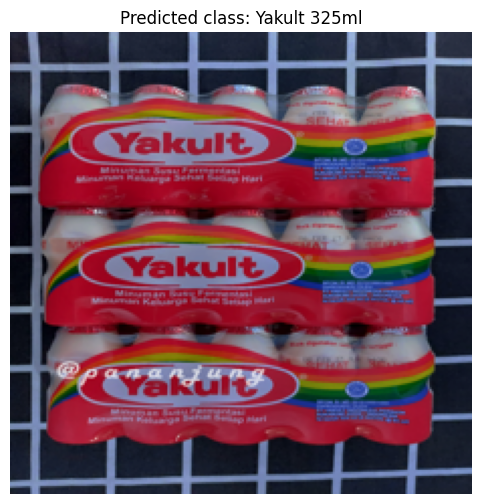

In [15]:
# Test the model on a new image
import io
from PIL import Image
from google.colab.files import upload
uploaded = upload()

for filename in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=filename, length=len(uploaded[filename])))

    # Load the uploaded image
    image = Image.open(io.BytesIO(uploaded[filename]))

    # Preprocess the image
    image = image.resize((229, 229))
    image_array = np.array(image) / 255.0
    image_tensor = np.expand_dims(image_array, axis=0)

    # Make predictions
    predictions = model.predict(image_tensor)
    predicted_class = np.argmax(predictions[0])

    # Display the image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Predicted class: {list(classes_train.keys())[list(classes_train.values()).index(predicted_class)]}")
    plt.axis('off')
    plt.show()

In [16]:
#save your model in the SavedModel format
export_dir = 'resnet50v2/saved_model'
tf.saved_model.save(model, export_dir)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the model.
with open('resnet_model.tflite', 'wb') as f:
  f.write(tflite_model)